# ACTPol + SPT-3G combined fit

## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np

Print versions used



In [2]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.20.2
Matplotlib : 3.4.1
   GetDist : 1.1.4


## Definitions

Define CMB & nuisance parameter names.



In [3]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "tau"]

Define SPT nuisance parameters

In [4]:
spt3g_params = [
    "kappa",
    "Dl_Poisson_90x90",
    "Dl_Poisson_90x150",
    "Dl_Poisson_90x220",
    "Dl_Poisson_150x150",
    "Dl_Poisson_150x220",
    "Dl_Poisson_220x220",
    "ADust_TE_150",
    "AlphaDust_TE",
    "ADust_EE_150",
    "AlphaDust_EE",
    "mapTcal90",
    "mapTcal150",
    "mapTcal220",
    "mapPcal90",
    "mapPcal150",
    "mapPcal220",
]

Set a dictionnary holding the path to the MCMC chains and its name

In [132]:
mcmc_samples = {
    "Planck 2018 - low-$\ell$ TE + TT+TE+EE": "data/planck+lowl/default/tt_te_ee",
    "ACTPol": "data/actpol/act_tau_prior",
    "SPT-3G": "data/spt3g/default/te_ee",
    "SPTPol": "data/sptpol/default/te_ee",
    "ACTPol + SPT-3G": "data/actpol+spt3g",
    "ACTPol - Neff": "data/actpol/neff",
    "SPT-3G - Neff": "data/spt3g/neff",
    "ACTPol + SPT-3G - Neff": "data/actpol+spt3g/neff",
    "ACTPol - nrun": "data/actpol/nrun",
    "SPT-3G - nrun": "data/spt3g/nrun",
    "ACTPol + SPT-3G - nrun": "data/actpol+spt3g/nrun",
    "Planck 2018 - low-$\ell$ TE + TT+TE+EE - nrun": "data/planck+lowl/nrun",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol - nrun": "data/planck_lmax650+actpol",
    "Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G - nrun": "data/planck_lmax650+spt3g",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol + SPT-3G - nrun": "data/planck_lmax650+actpol+spt3g",
    "Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ($\ell^\mathrm{TT}\geq1800$) - nrun": "data/planck_full+actpol_lmin1800",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (wide) - nrun": "data/planck_lmax650+actpol_wide",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (deep) - nrun": "data/planck_lmax650+actpol_deep",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol TT - nrun": "data/planck_lmax650+actpol_tt",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol TE - nrun": "data/planck_lmax650+actpol_te",
    "Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol EE - nrun": "data/planck_lmax650+actpol_ee",
    "Planck 2018 TT ($2\leq\ell\leq650$) + SPT-3G - nrun": "data/planck_lmax650+lowl+spt3g",
    "Planck 2018 TT ($2\leq\ell\leq650$) + ACTPol - nrun": "data/planck_lmax650+lowl+actpol",
    "Planck 2018 TT ($2\leq\ell\leq650$) + ACTPol + SPT-3G - nrun": "data/planck_lmax650+lowl+actpol+spt3g",
}
label_samples = list(mcmc_samples.keys())
sub_samples = {k: v for k, v in mcmc_samples.items() if re.match(".*(lmax650.*lowl|lmin1800).*", v)}

## MCMC chains

Let's plot the chains size

In [125]:
from cobaya_utilities.tools import print_chains_size

print_chains_size(sub_samples)

Have a look at how chains evolve with time and check convergence or not.



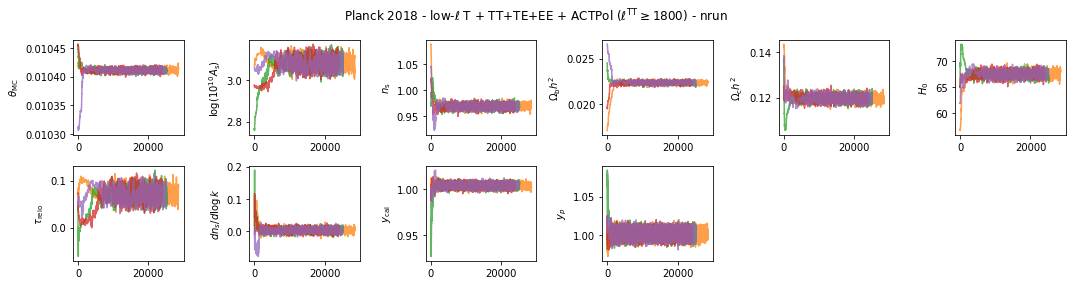

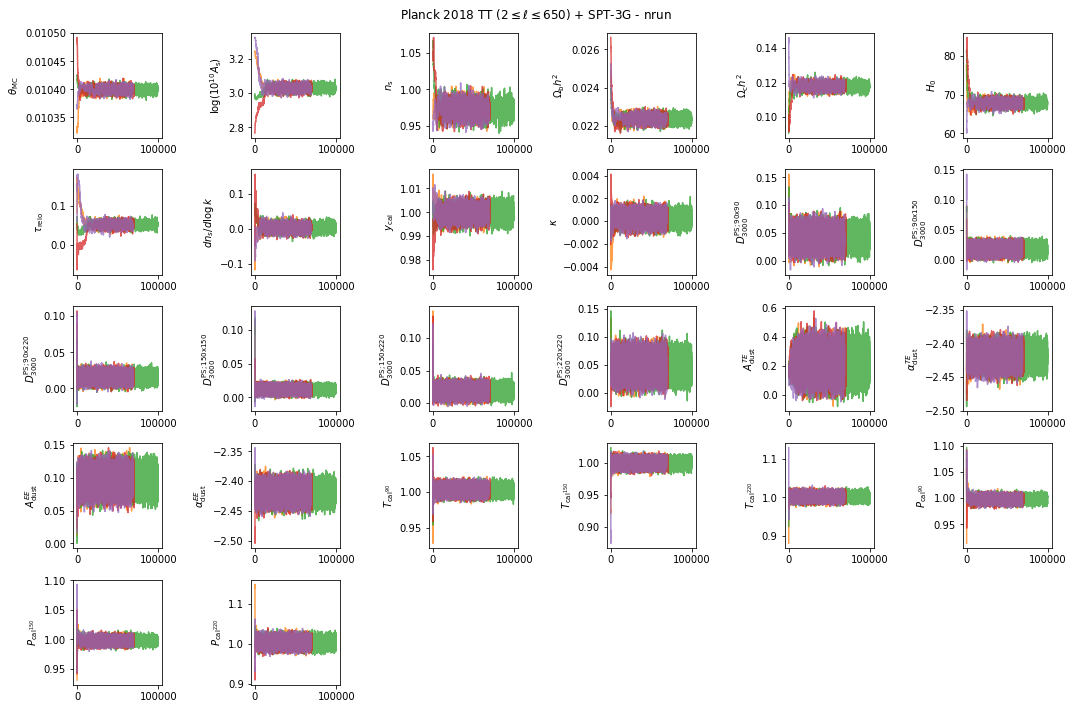

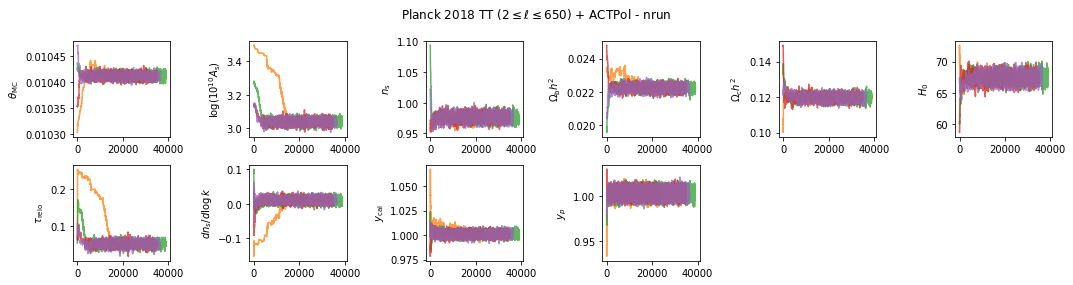

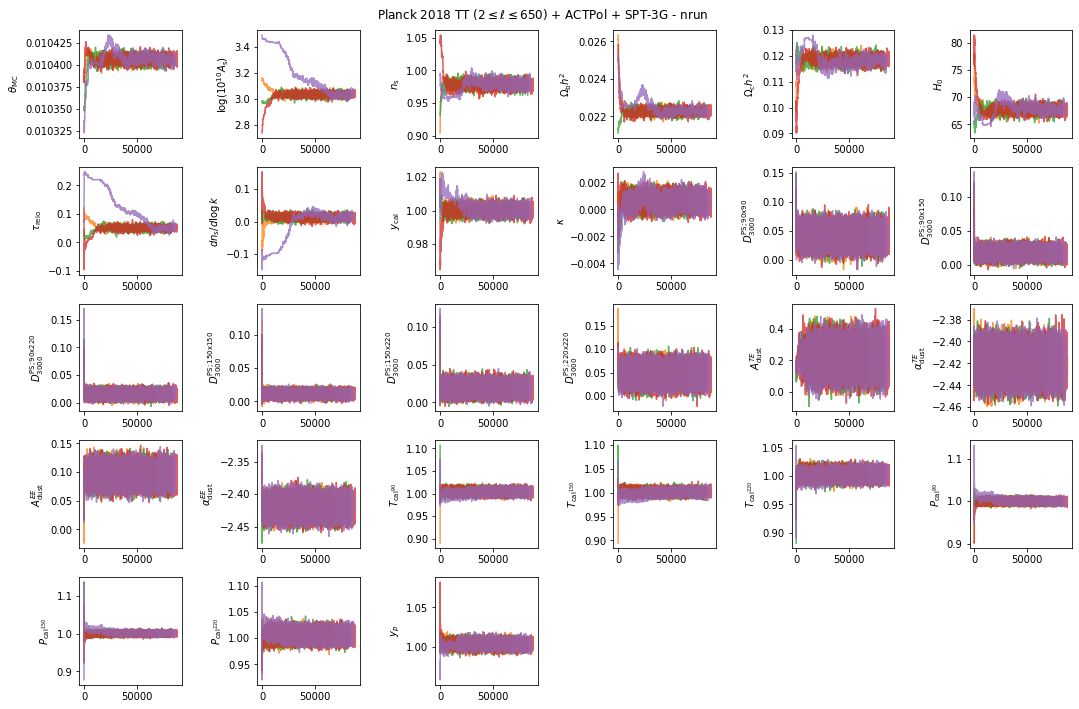

In [126]:
from cobaya_utilities.tools import plot_chains, print_results

for k, v in sub_samples.items():
    nuisance_params = []
    nuisance_params += ["A_planck"] if "Planck" in k else []
    nuisance_params += spt3g_params if "SPT-3G" in k else []
    nuisance_params += ["yp2"] if "ACTPol" in k else []
    cmb_params = cosmo_params.copy()
    cmb_params += ["nnu"] if "neff" in v else []
    cmb_params += ["nrun"] if "nrun" in k else []
    plot_chains(
        v, params=cmb_params + nuisance_params, title=k, ncol=6, ignore_rows=0.0
    )

Let's plot also the Gelman $R-1$ parameter and acceptance rate progress

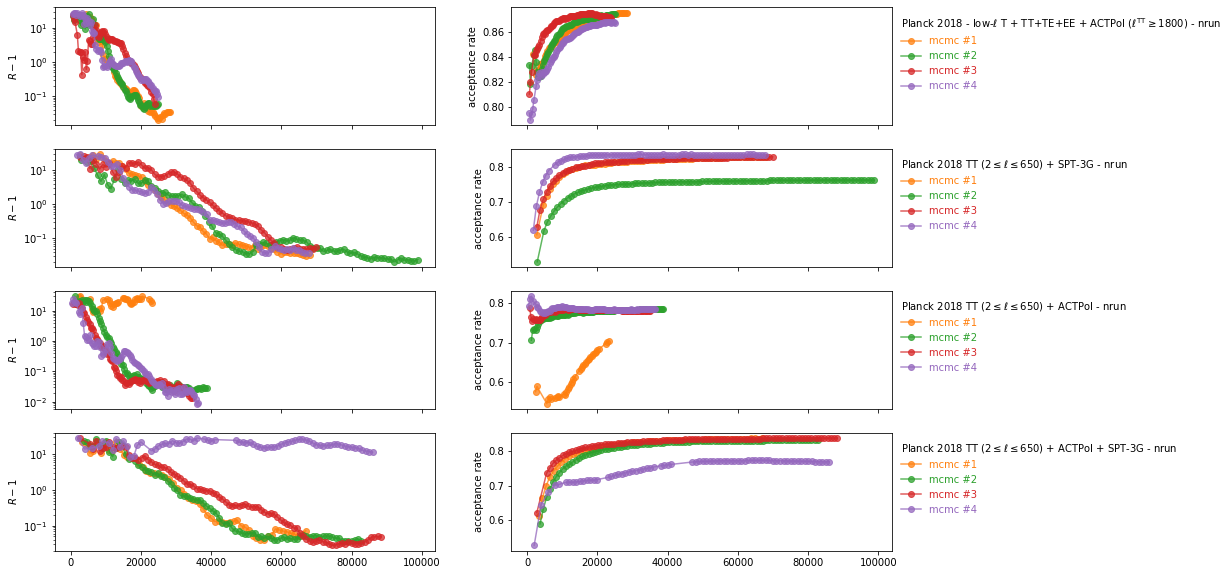

In [127]:
from cobaya_utilities.tools import plot_progress

plot_progress(sub_samples)

## MCMC distributions



Define global plot settings

In [9]:
def get_default_settings():
    from getdist.plots import GetDistPlotSettings

    plot_settings = GetDistPlotSettings()
    plot_settings.num_plot_contours = 3
    plot_settings.solid_colors = "tab10"
    plot_settings.line_styles = "tab10"
    plot_settings.linewidth = 2
    plot_settings.legend_fontsize = 15
    plot_settings.legend_colored_text = True
    return plot_settings

Load MCMC samples



In [128]:
from getdist import loadMCSamples

samples = [
    loadMCSamples(os.path.join(path, "mcmc"), settings={"ignore_rows": 0.4})
    for path in mcmc_samples.values()
]

In [11]:
from getdist import plots
from scipy.stats import norm


def get_sample_range(keywords):
    r = re.compile(keywords)
    return [i for i, k in enumerate(mcmc_samples.keys()) if r.match(k)]


def show_inputs(axes, inputs, colors=None):
    for i, ax in enumerate(axes):
        xmin, xmax, ymin, ymax = ax.axis()
        x = np.linspace(xmin, xmax, 100)
        for j, values in enumerate(inputs):
            mean, sigma = values[i]
            if mean is None:
                continue
            y = norm.pdf(x, mean, sigma)
            ax.plot(x, y / np.max(y), color=colors[j], ls="--")


def show_tau_prior(ax, loc=0.054, scale=0.0073):
    show_inputs([ax], inputs=[[(loc, scale)]], colors=["gray"])
    ax.legend([r"$\tau$ prior"], loc="upper left", bbox_to_anchor=(1, 1))

## Comparison SPT-3G/SPTPol with published results

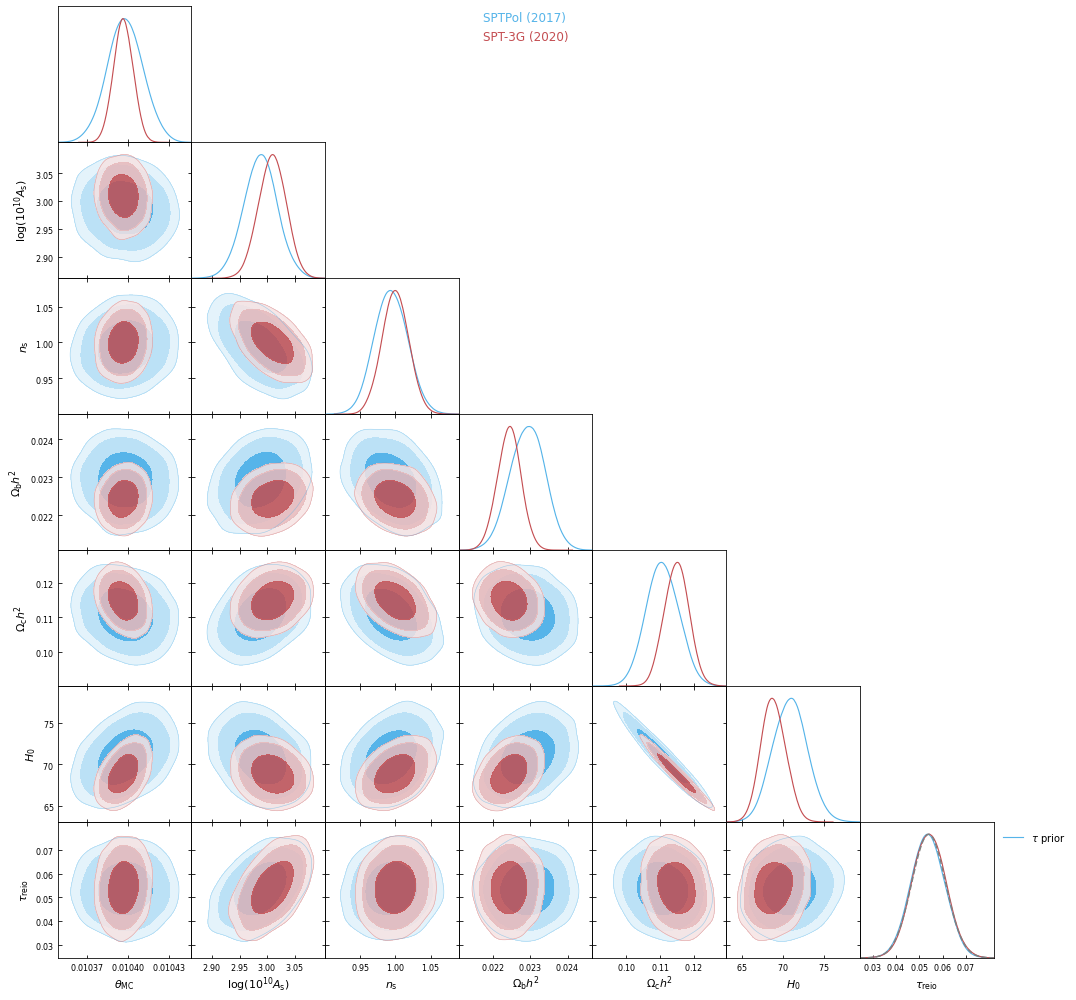

In [12]:
colors = ["#56B4E9", "#C44E52"]
sample_range = get_sample_range("^SPTPol$") + get_sample_range("^SPT-3G$")
labels = ["SPTPol (2017)", "SPT-3G (2020)"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sample_range],
    cosmo_params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)
show_tau_prior(g.subplots[-1, -1])

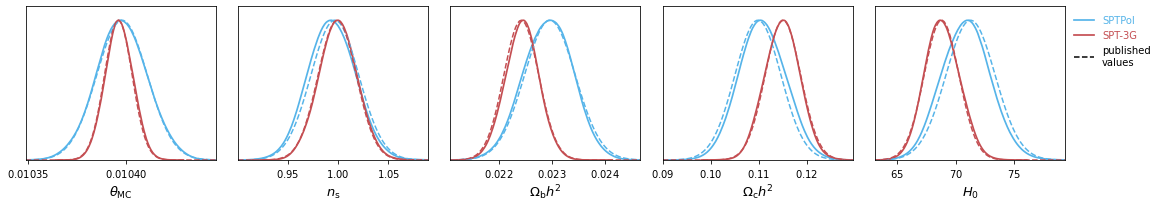

In [13]:
dutcher_results = [
    (1.03961 / 100, 0.00071 / 100),
    (0.999, 0.019),
    (0.02242, 0.00033),
    (0.1150, 0.0037),
    (68.8, 1.5),
]
henning_results = [
    (1.0398 / 100, 0.0013 / 100),
    (0.9967, 0.0238),
    (2.296 / 100, 0.048 / 100),
    (0.1098, 0.0048),
    (71.29, 2.12),
]
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=15)
g.plots_1d(
    [samples[i] for i in sample_range],
    params,
    colors=colors,
    nx=len(params),
    legend_labels=[],
)

ax = g.subplots[-1, -1]
ax.plot([], [], "--k")
ax.legend(
    ["SPTPol", "SPT-3G", "published\nvalues"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
)
show_inputs(*g.subplots, inputs=[henning_results, dutcher_results], colors=colors)

Checking nuisance parameters of SPT-3G

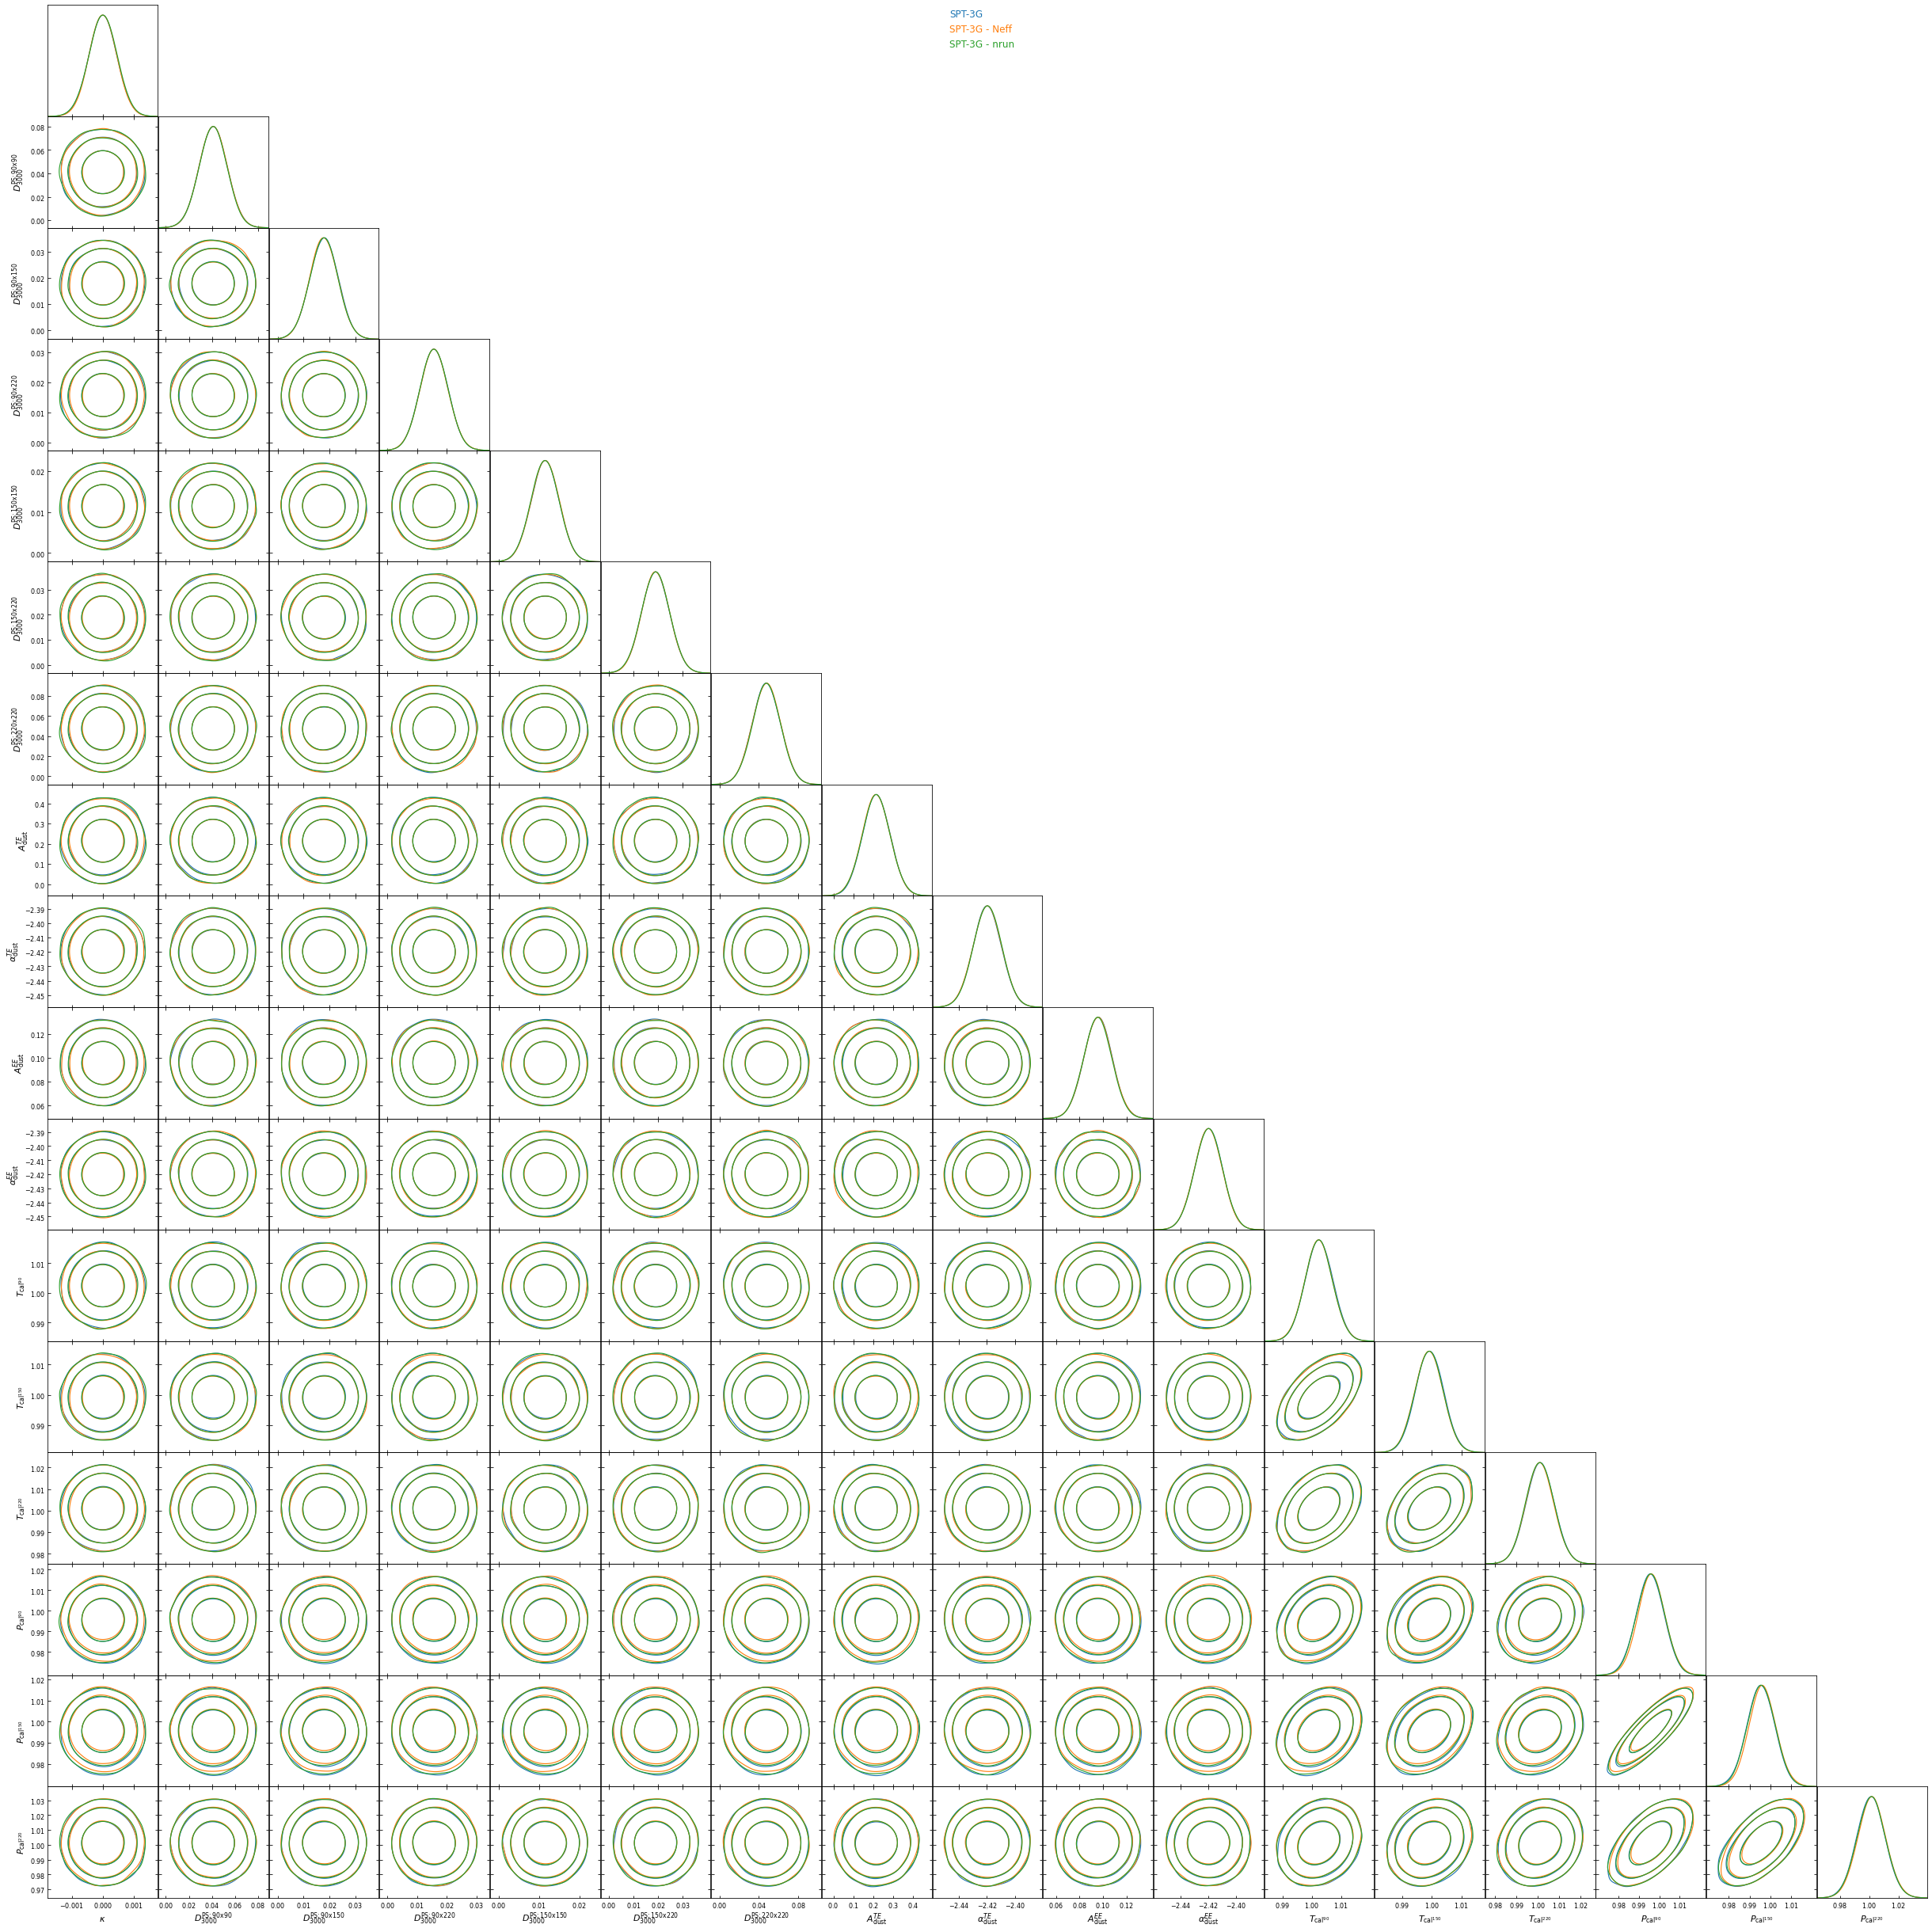

In [14]:
sample_range = get_sample_range("SPT-3G")
colors = [f"C{i}" for i in range(len(sample_range))]
legend_labels = [list(mcmc_samples.keys())[i] for i in sample_range]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sample_range],
    spt3g_params,
    filled=False,
    legend_labels=legend_labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

## $\Lambda$CDM

### ACTPol + SPT3G vs. Planck 2018

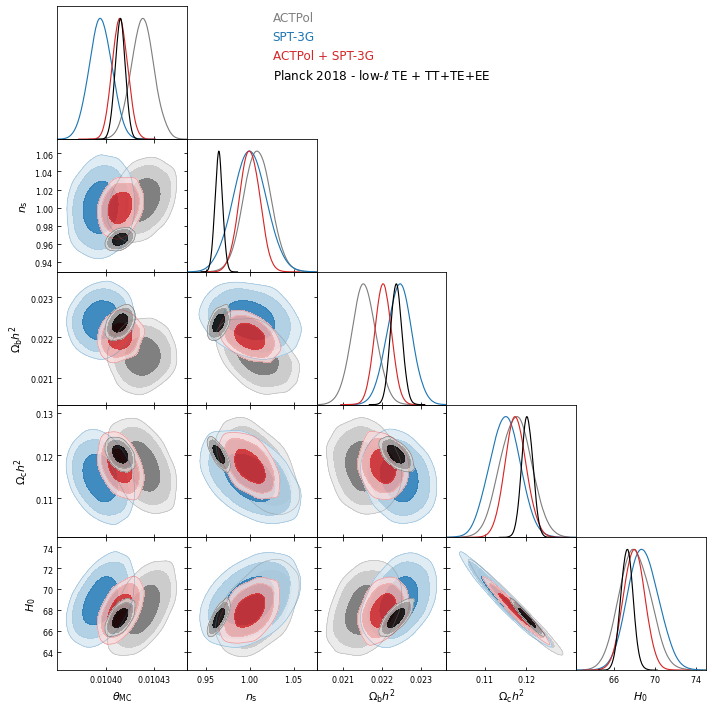

In [133]:
sr = (
    get_sample_range("ACTPol$")
    + get_sample_range("^SPT-3G$")
    + get_sample_range("ACTPol.*SPT-3G$")
    + get_sample_range("Planck 2018.*low.*TE.*TT\+.*EE$")
)
params = ["cosmomc_theta", "ns", "ombh2", "omch2", "H0"]
labels = [label_samples[i] for i in sr]
colors = ["gray", "tab:blue", "tab:red", "black"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

In [134]:
print_results([samples[i] for i in sr], cosmo_params, labels)

$\theta_\mathrm{MC}$  \
ACTPol                                  $0.0104227\pm 0.0000071    $   
SPT-3G                                  $0.0103965\pm 0.0000071    $   
ACTPol + SPT-3G                         $0.0104086\pm 0.0000048    $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.0104087\pm 0.0000032    $   

                                        $\log(10^{10} A_\mathrm{s})$  \
ACTPol                                  $3.048\pm 0.030            $   
SPT-3G                                  $3.010\pm 0.025            $   
ACTPol + SPT-3G                         $3.028\pm 0.017            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $3.045\pm 0.016            $   

                                                   $n_\mathrm{s}   $  \
ACTPol                                  $1.009\pm 0.016            $   
SPT-3G                                  $0.9998\pm 0.019           $   
ACTPol + SPT-3G                         $0.9998\pm 0.011           $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.9648\pm 0.0044          $   

                                              $\Omega_\mathrm{b}h^2$  \
ACTPol                                  $0.02153\pm 0.00031        $   
SPT-3G                                  $0.02243\pm 0.00032        $   
ACTPol + SPT-3G                         $0.02202\pm 0.00021        $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.02236\pm 0.00015        $   

                                              $\Omega_\mathrm{c}h^2$  \
ACTPol                                  $0.1175\pm 0.0038          $   
SPT-3G                                  $0.1149\pm 0.0037          $   
ACTPol + SPT-3G                         $0.1175\pm 0.0026          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.1202\pm 0.0014          $   

                                                $\tau_\mathrm{reio}$  \
ACTPol                                  $0.064\pm 0.014            $   
SPT-3G                                  $0.0542\pm 0.0073          $   
ACTPol + SPT-3G                         $0.0541\pm 0.0072          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.0541\pm 0.0077          $   

                                        $H_0                       $  
ACTPol                                  $68.0\pm 1.5               $  
SPT-3G                                  $68.9\pm 1.5               $  
ACTPol + SPT-3G                         $68.0\pm 1.0               $  
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $67.25\pm 0.60             $

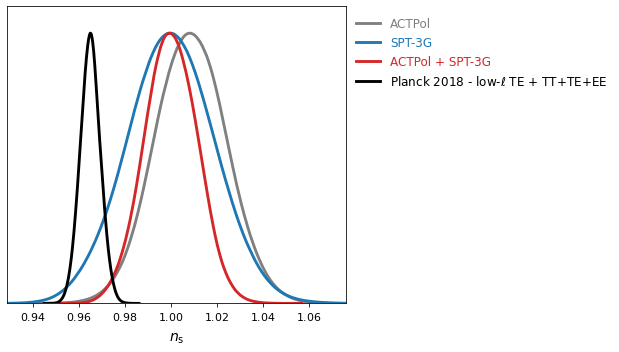

In [135]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["ns"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(
    labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12
);

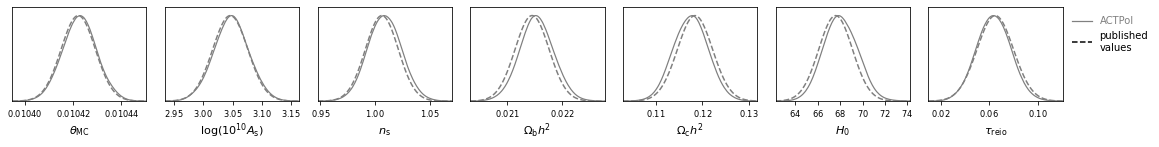

In [17]:
choi_results = [
    (104.221 / 10 ** 4, 0.071 / 10 ** 4),
    (3.046, 0.030),
    (1.006, 0.015),
    (2.145 / 100, 0.031 / 100),
    (11.84 / 100, 0.38 / 100),
    (67.6, 1.5),
    (0.065, 0.015),
]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=15)
g.plots_1d(
    [samples[i] for i in get_sample_range("^ACTPol$")],
    cosmo_params,
    colors=["gray"],
    nx=len(cosmo_params),
    legend_labels=[],
)

ax = g.subplots[-1, -1]
ax.plot([], [], "--k")
ax.legend(
    ["ACTPol", "published\nvalues"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
)
show_inputs(*g.subplots, inputs=[choi_results], colors=["gray"])

## $\Lambda$CDM extensions

### $N_\mathrm{eff}$

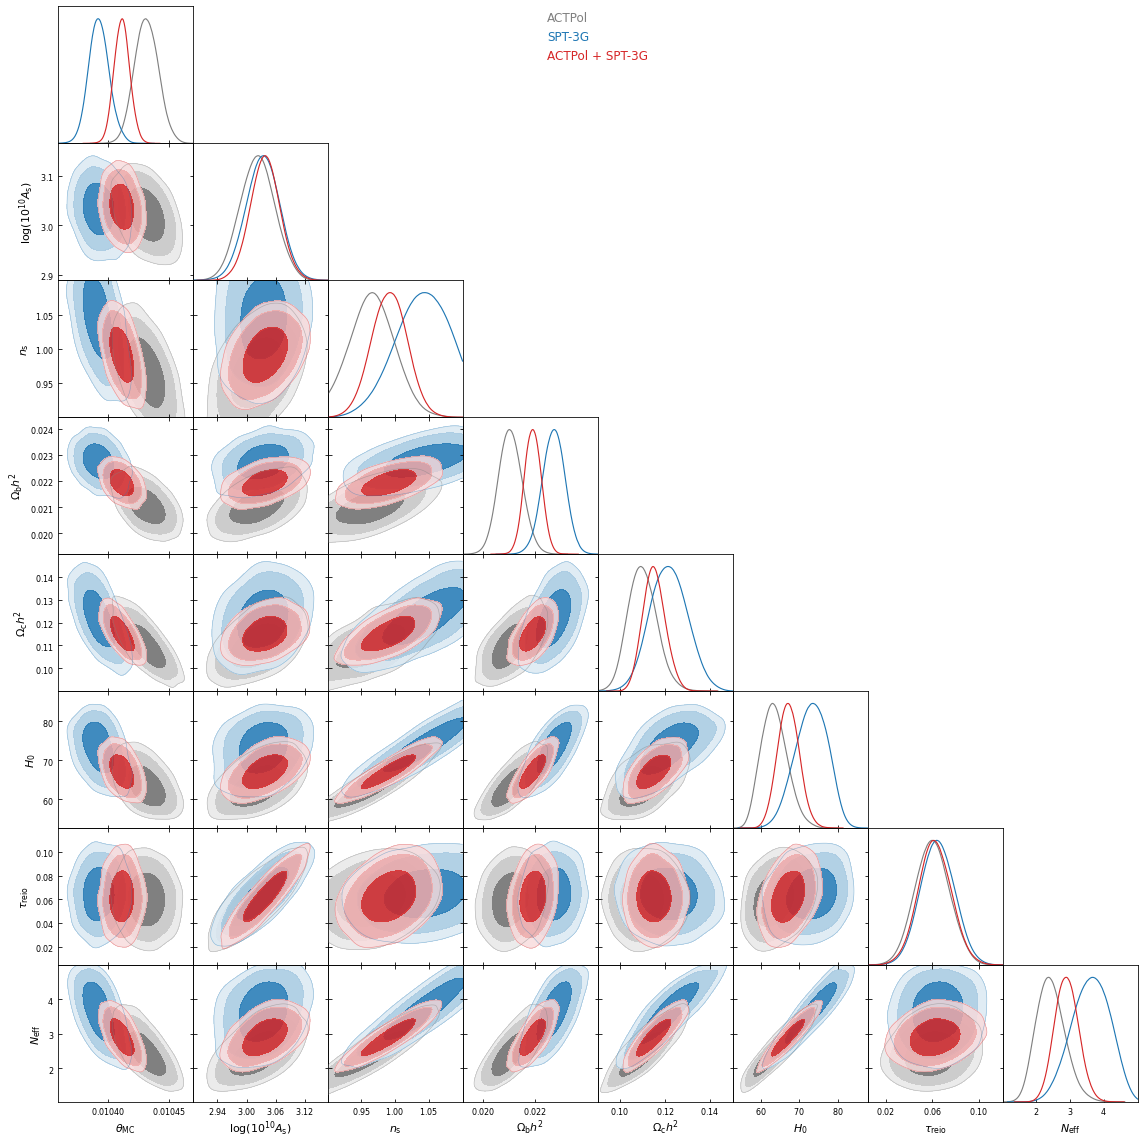

In [136]:
sr = (
    get_sample_range("^ACTPol - Neff$")
    + get_sample_range("^SPT-3G - Neff$")
    + get_sample_range("ACTPol.*SPT-3G.*Neff$")
)
colors = ["gray", "tab:blue", "tab:red"]
labels = ["ACTPol", "SPT-3G", "ACTPol + SPT-3G"]

g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    cosmo_params + ["nnu"],
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

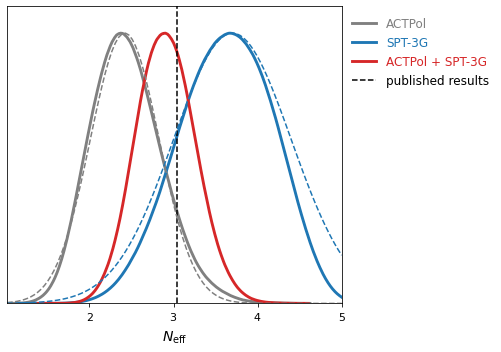

In [137]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nnu"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.axvline(3.046, c="k", ls="--")
ax.legend(
    labels + ["published results"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
    fontsize=12,
)

aiola_results = [(2.42, 0.41)]
balkenhol_results = [(3.70, 0.70)]
show_inputs(*g.subplots, inputs=[aiola_results, balkenhol_results], colors=colors)

In [138]:
print_results([samples[i] for i in sr], params=cosmo_params + ["nnu"], labels=labels)

$\theta_\mathrm{MC}$  $\log(10^{10} A_\mathrm{s})$  \
ACTPol           $0.0104314\pm 0.0000098    $  $3.023\pm 0.035            $   
SPT-3G           $0.0103924\pm 0.0000085    $  $3.034\pm 0.034            $   
ACTPol + SPT-3G  $0.0104112\pm 0.0000065    $  $3.038\pm 0.030            $   

                            $n_\mathrm{s}   $        $\Omega_\mathrm{b}h^2$  \
ACTPol           $0.968\pm 0.032            $  $0.02106\pm 0.00046        $   
SPT-3G           $1.036^{+0.047}_{-0.029}   $  $0.02274\pm 0.00044        $   
ACTPol + SPT-3G  $0.991\pm 0.026            $  $0.02194\pm 0.00033        $   

                       $\Omega_\mathrm{c}h^2$          $\tau_\mathrm{reio}$  \
ACTPol           $0.1100^{+0.0058}_{-0.0068}$  $0.060\pm 0.015            $   
SPT-3G           $0.1216\pm 0.0082          $  $0.064\pm 0.015            $   
ACTPol + SPT-3G  $0.1151^{+0.0046}_{-0.0053}$  $0.062\pm 0.014            $   

                            $N_\mathrm{eff} $  $H_0                       $  
ACTPol           $2.44^{+0.37}_{-0.47}      $  $63.6^{+3.0}_{-3.8}        $  
SPT-3G           $3.62^{+0.61}_{-0.53}      $  $73.1^{+4.7}_{-3.9}        $  
ACTPol + SPT-3G  $2.91\pm 0.35              $  $67.2\pm 2.8               $

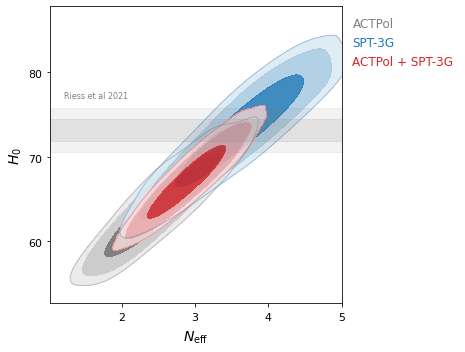

In [139]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plot_2d([samples[i] for i in sr], "nnu", "H0", filled=True, colors=colors)
g.add_legend(labels, colored_text=True, legend_loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
g.add_y_bands(73.2, 1.3)
g.add_text("Riess et al 2021", 0.05, 0.7, fontsize=8, color="gray")

### $\frac{dn_s}{d\log k}$

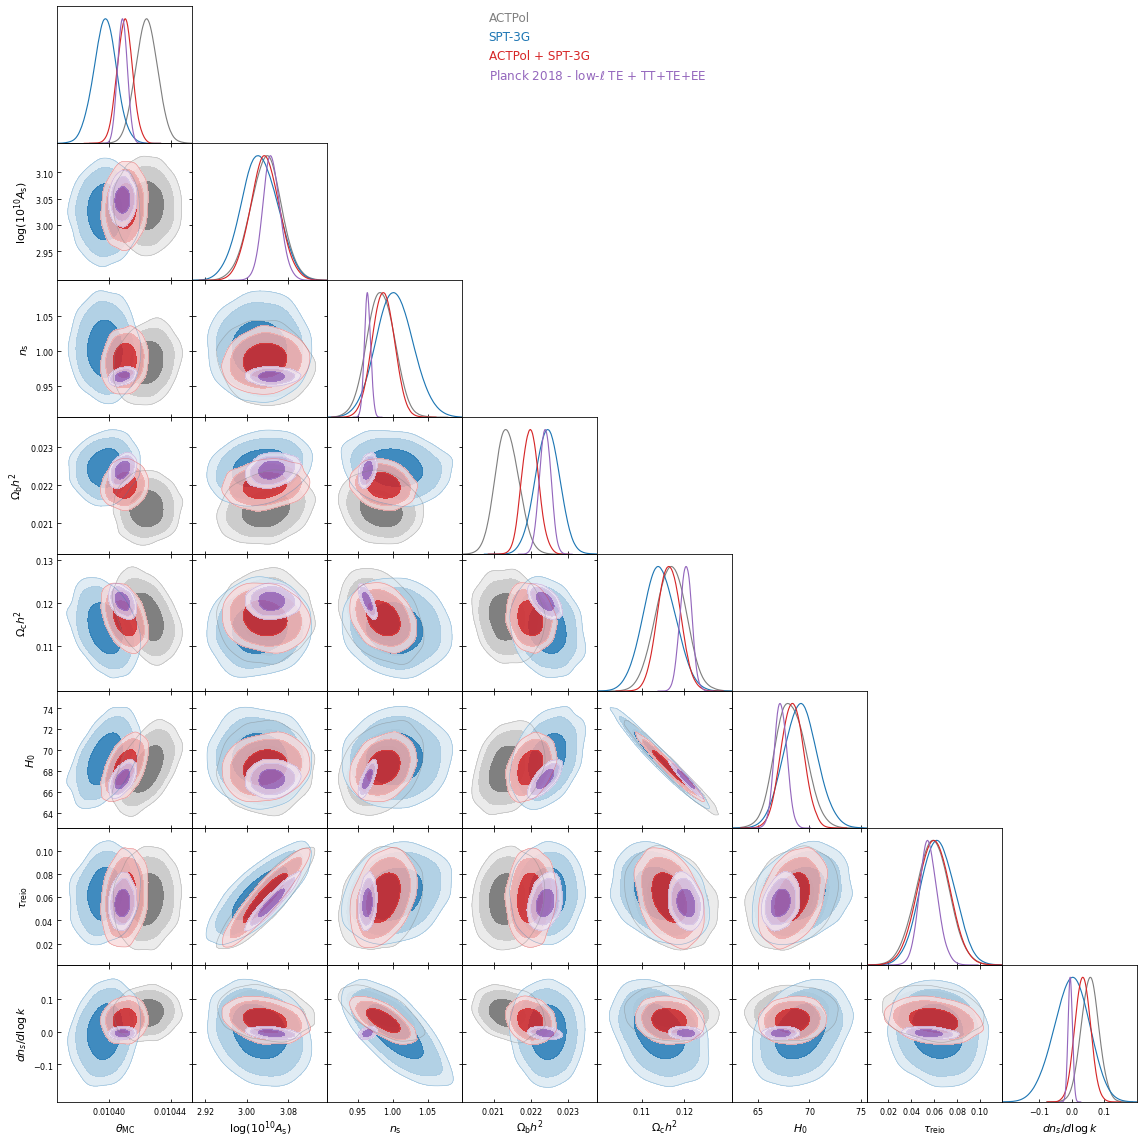

In [142]:
sr = (
    get_sample_range("^ACTPol - nrun$")
    + get_sample_range("^SPT-3G - nrun$")
    + get_sample_range("ACTPol \+ SPT-3G - nrun$")
    + get_sample_range("Planck 2018 TT \+ ACTPol \+ SPT-3G - nrun$")
    + get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun$")
)

colors = ["gray", "tab:blue", "tab:red", "tab:purple", "black"]
labels = [label_samples[i].replace(" - nrun", "") for i in sr]
params = cosmo_params + ["nrun"]
g = plots.get_subplot_plotter(settings=get_default_settings())
g.triangle_plot(
    [samples[i] for i in sr],
    params,
    filled=True,
    legend_labels=labels,
    colors=colors,
    diag1d_kwargs={"colors": colors},
)

In [143]:
print_results([samples[i] for i in sr], params, labels)

$\theta_\mathrm{MC}$  \
ACTPol                                  $0.0104244\pm 0.0000072    $   
SPT-3G                                  $0.0103972\pm 0.0000075    $   
ACTPol + SPT-3G                         $0.0104101\pm 0.0000051    $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.0104086\pm 0.0000031    $   

                                        $\log(10^{10} A_\mathrm{s})$  \
ACTPol                                  $3.037\pm 0.030            $   
SPT-3G                                  $3.025\pm 0.034            $   
ACTPol + SPT-3G                         $3.035\pm 0.028            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $3.048^{+0.016}_{-0.017}   $   

                                                   $n_\mathrm{s}   $  \
ACTPol                                  $0.983\pm 0.020            $   
SPT-3G                                  $1.003\pm 0.026            $   
ACTPol + SPT-3G                         $0.986\pm 0.016            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.9637\pm 0.0045          $   

                                              $\Omega_\mathrm{b}h^2$  \
ACTPol                                  $0.02137\pm 0.00032        $   
SPT-3G                                  $0.02244\pm 0.00033        $   
ACTPol + SPT-3G                         $0.02198\pm 0.00022        $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.02238\pm 0.00016        $   

                                              $\Omega_\mathrm{c}h^2$  \
ACTPol                                  $0.1169\pm 0.0036          $   
SPT-3G                                  $0.1142\pm 0.0039          $   
ACTPol + SPT-3G                         $0.1165\pm 0.0027          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.1204\pm 0.0014          $   

                                                $\tau_\mathrm{reio}$  \
ACTPol                                  $0.059\pm 0.015            $   
SPT-3G                                  $0.063\pm 0.015            $   
ACTPol + SPT-3G                         $0.060\pm 0.014            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $0.0552^{+0.0073}_{-0.0083}$   

                                                   $dn_s/d\log k   $  \
ACTPol                                  $0.056\pm 0.028            $   
SPT-3G                                  $-0.001\pm 0.055           $   
ACTPol + SPT-3G                         $0.034\pm 0.024            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $-0.0047\pm 0.0068         $   

                                        $H_0                       $  
ACTPol                                  $68.2\pm 1.5               $  
SPT-3G                                  $69.1\pm 1.6               $  
ACTPol + SPT-3G                         $68.4\pm 1.1               $  
Planck 2018 - low-$\ell$ TE + TT+TE+EE  $67.22\pm 0.61             $

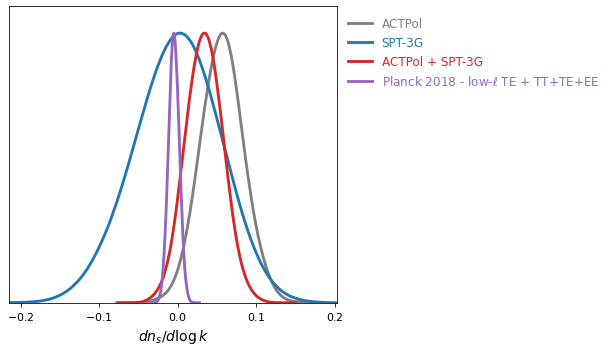

In [144]:
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], "nrun", colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(
    labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12
);

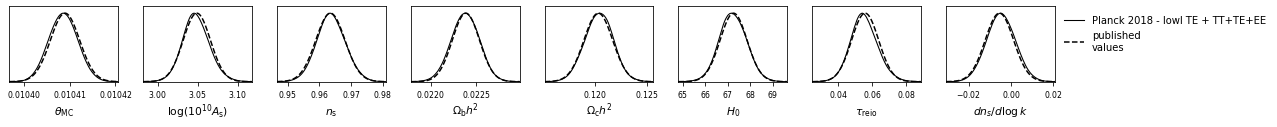

In [149]:
planck_results = [
    (1.04090 / 100, 0.00032 / 100),
    (3.049, 0.017),
    (0.9635, 0.0046),
    (0.02239, 0.00015),
    (0.1203, 0.0014),
    (67.25, 0.60),
    (0.0558, 0.0080),
    (-0.0055, 0.0067),
]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=15)
g.plots_1d(
    [samples[i] for i in get_sample_range("Planck.*low.*TE \+ TT\+TE\+EE.*nrun$")],
    params,
    colors=["black"],
    nx=len(params),
    legend_labels=[],
)

ax = g.subplots[-1, -1]
ax.plot([], [], "--k")
ax.legend(
    ["Planck 2018 - lowl TE + TT+TE+EE", "published\nvalues"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
)
show_inputs(g.subplots.flatten(), inputs=[planck_results], colors=["black"])

#### Comparisons with Aiola et al.

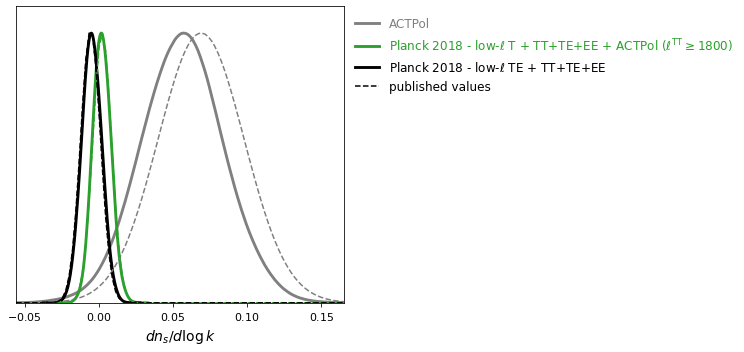

In [150]:
sr = (
    get_sample_range("^ACTPol - nrun$")
    + get_sample_range("Planck.*1800.*nrun$")
    + get_sample_range("Planck.*low.*TE \+ TT\+TE\+EE.*nrun$")
)

sample_cosmomc = loadMCSamples(
    "data/actpol/nrun/cosmomc/ACTPol_nrun",
    settings={"ignore_rows": 0.4},
)

colors = ["gray", "tab:green", "black"]
labels = [label_samples[i].replace(" - nrun", "") for i in sr]
g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d(
    [samples[i] for i in sr],# + [sample_cosmomc],
    ["nrun"],
    colors=colors,
    legend_labels=[],
)

ax = g.subplots[-1, -1]
ax.plot([], [], "--k")
ax.legend(
    labels + ["published values"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labelcolor="mfc",
    fontsize=12,
)
aiola1_results = [(0.069, 0.029)]
aiola2_results = [(0.0023, 0.0063)]
planck_results = [(-0.0055, 0.0067)]
show_inputs(*g.subplots, inputs=[aiola1_results, aiola2_results, planck_results], colors=colors)

In [151]:
print_results([samples[i] for i in sr], cosmo_params + ["nrun"], labels)

$\theta_\mathrm{MC}$  \
ACTPol                                              $0.0104244\pm 0.0000072    $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.0104108\pm 0.0000030    $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0104086\pm 0.0000031    $   

                                                    $\log(10^{10} A_\mathrm{s})$  \
ACTPol                                              $3.037\pm 0.030            $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $3.083\pm 0.025            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $3.048^{+0.016}_{-0.017}   $   

                                                               $n_\mathrm{s}   $  \
ACTPol                                              $0.983\pm 0.020            $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.9695\pm 0.0042          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.9637\pm 0.0045          $   

                                                          $\Omega_\mathrm{b}h^2$  \
ACTPol                                              $0.02137\pm 0.00032        $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.02236\pm 0.00014        $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.02238\pm 0.00016        $   

                                                          $\Omega_\mathrm{c}h^2$  \
ACTPol                                              $0.1169\pm 0.0036          $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.1196\pm 0.0013          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.1204\pm 0.0014          $   

                                                            $\tau_\mathrm{reio}$  \
ACTPol                                              $0.059\pm 0.015            $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.071\pm 0.013            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0552^{+0.0073}_{-0.0083}$   

                                                               $dn_s/d\log k   $  \
ACTPol                                              $0.056\pm 0.028            $   
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $0.0021\pm 0.0062          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $-0.0047\pm 0.0068         $   

                                                    $H_0                       $  
ACTPol                                              $68.2\pm 1.5               $  
Planck 2018 - low-$\ell$ T + TT+TE+EE + ACTPol ...  $67.55\pm 0.57             $  
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $67.22\pm 0.61             $

#### Planck+ACTPol vs. Planck+SPT-3G

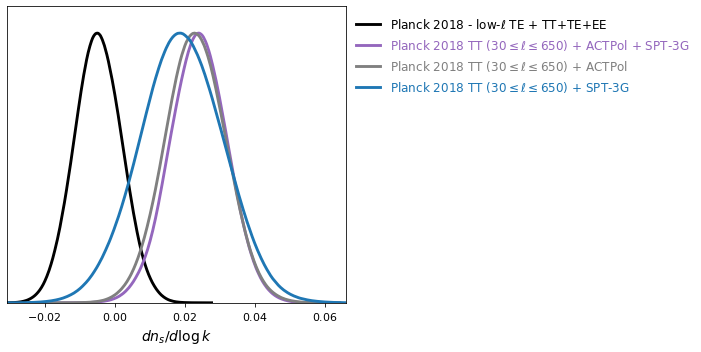

In [178]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ ACTPol.*SPT-3G.*nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ ACTPol - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ SPT-3G - nrun")
)

labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "tab:purple", "gray", "tab:blue"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], "nrun", colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12);

In [179]:
print_results([samples[i] for i in sr], cosmo_params + ["nrun"], labels)

$\theta_\mathrm{MC}$  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0104086\pm 0.0000031    $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.0104056\pm 0.0000041    $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.0104102\pm 0.0000051    $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.0103986\pm 0.0000052    $   

                                                    $\log(10^{10} A_\mathrm{s})$  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $3.048^{+0.016}_{-0.017}   $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $3.040\pm 0.026            $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $3.052\pm 0.027            $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $3.041\pm 0.028            $   

                                                               $n_\mathrm{s}   $  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.9637\pm 0.0045          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.9780\pm 0.0052          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.9754\pm 0.0055          $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.9770\pm 0.0089          $   

                                                          $\Omega_\mathrm{b}h^2$  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.02238\pm 0.00016        $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.02217\pm 0.00016        $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.02209\pm 0.00018        $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.02229\pm 0.00019        $   

                                                          $\Omega_\mathrm{c}h^2$  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.1204\pm 0.0014          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.1186\pm 0.0016          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.1199\pm 0.0017          $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.1175\pm 0.0018          $   

                                                            $\tau_\mathrm{reio}$  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0552^{+0.0073}_{-0.0083}$   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.056\pm 0.013            $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.060\pm 0.014            $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.059\pm 0.014            $   

                                                               $dn_s/d\log k   $  \
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $-0.0047\pm 0.0068         $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $0.0240\pm 0.0082          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.0231\pm 0.0087          $   
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $0.019\pm 0.012            $   

                                                    $H_0                       $  
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $67.22\pm 0.61             $  
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol +...  $67.58\pm 0.67             $  
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $67.19\pm 0.75             $  
Planck 2018 TT ($30\leq\ell\leq650$) + SPT-3G       $67.81\pm 0.79             $

#### Planck with or without low-$\ell$ data

##### ACTPol only

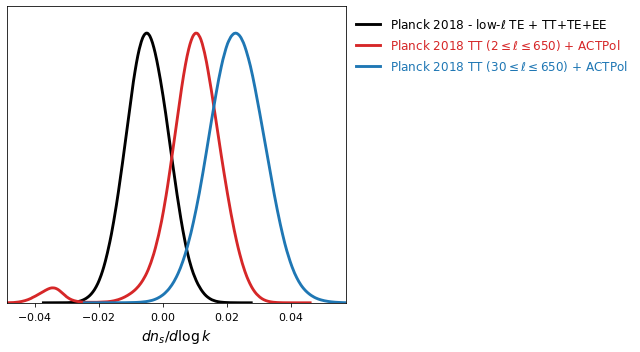

In [177]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$2.*\) \+ ACTPol - nrun$")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ ACTPol - nrun$")
)

labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "tab:red", "tab:blue"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nrun"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12);

##### SPT-3G only 

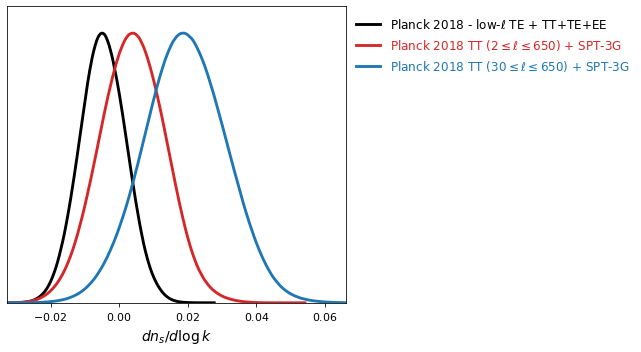

In [176]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$2.*\) \+ SPT-3G - nrun$")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ SPT-3G - nrun$")
)

labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "tab:red", "tab:blue"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nrun"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12);

##### ACTPol + SPT-3G 

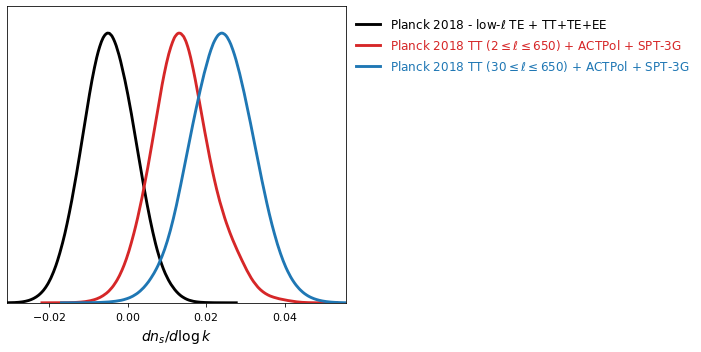

In [175]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$2.*\) \+ ACTPol \+ SPT-3G - nrun$")
    + get_sample_range("Planck 2018 TT \(\$30.*\) \+ ACTPol \+ SPT-3G - nrun$")
)

labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "tab:red", "tab:blue"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nrun"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12);

#### ACTPol wide vs. deep

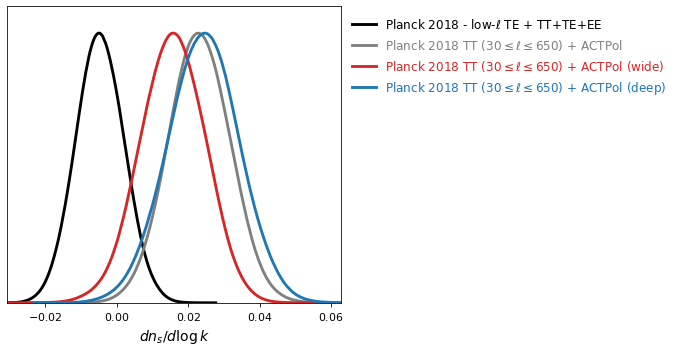

In [173]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\+ ACTPol - nrun")
    + get_sample_range(".*wide.*nrun")
    + get_sample_range(".*deep.*nrun")
)
labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "gray", "tab:red", "tab:blue"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nrun"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(
    labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12
);

In [170]:
print_results([samples[i] for i in sr], cosmo_params + ["nrun"], labels)

$\theta_\mathrm{MC}$  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.0104102\pm 0.0000051    $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0104086\pm 0.0000031    $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.0104125\pm 0.0000054    $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.0103990\pm 0.0000070    $   

                                                    $\log(10^{10} A_\mathrm{s})$  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $3.052\pm 0.027            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $3.048^{+0.016}_{-0.017}   $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $3.060\pm 0.029            $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $3.051\pm 0.029            $   

                                                               $n_\mathrm{s}   $  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.9754\pm 0.0055          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.9637\pm 0.0045          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.9732\pm 0.0062          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.9758\pm 0.0068          $   

                                                          $\Omega_\mathrm{b}h^2$  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.02209\pm 0.00018        $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.02238\pm 0.00016        $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.02221\pm 0.00020        $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.02205\pm 0.00021        $   

                                                          $\Omega_\mathrm{c}h^2$  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.1199\pm 0.0017          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.1204\pm 0.0014          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.1200\pm 0.0018          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.1192\pm 0.0019          $   

                                                            $\tau_\mathrm{reio}$  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.060\pm 0.014            $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $0.0552^{+0.0073}_{-0.0083}$   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.062\pm 0.014            $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.061\pm 0.014            $   

                                                               $dn_s/d\log k   $  \
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $0.0231\pm 0.0087          $   
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $-0.0047\pm 0.0068         $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.0156\pm 0.0091          $   
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $0.024\pm 0.010            $   

                                                    $H_0                       $  
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol       $67.19\pm 0.75             $  
Planck 2018 - low-$\ell$ TE + TT+TE+EE              $67.22\pm 0.61             $  
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $67.32\pm 0.80             $  
Planck 2018 TT ($30\leq\ell\leq650$) + ACTPol (...  $67.05\pm 0.86             $

### ACTPol TT vs. TE vs. EE

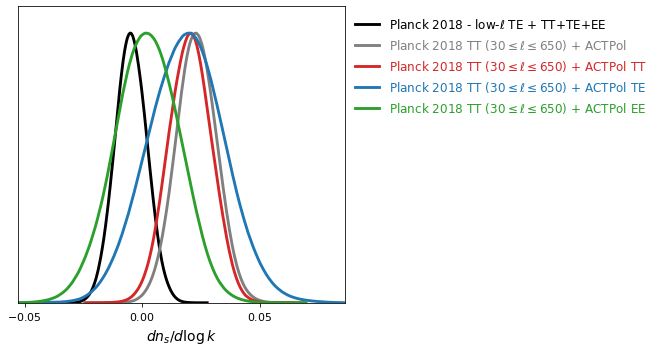

In [172]:
sr = (
    get_sample_range("Planck 2018 - low.*TE \+ TT\+TE\+EE - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\+ ACTPol - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\+ ACTPol TT - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\+ ACTPol TE - nrun")
    + get_sample_range("Planck 2018 TT \(\$30.*\+ ACTPol EE - nrun")
)

labels = [label_samples[i].replace(" - nrun", "") for i in sr]
colors = ["black", "gray", "tab:red", "tab:blue", "tab:green"]

g = plots.get_subplot_plotter(settings=get_default_settings(), width_inch=5)
g.plots_1d([samples[i] for i in sr], ["nrun"], colors=colors, legend_labels=[])
ax = g.subplots[-1, -1]
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 1), labelcolor="mfc", fontsize=12);